In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_iris
from PIL import Image
import torchvision.transforms as transforms
import torch



In [2]:
def image_to_tensor(image_path):
    # Define the transformation
    transform = transforms.Compose([
        transforms.Grayscale(),   # Convert to grayscale
        transforms.Resize((28, 28)),  # Resize to 28x28
        transforms.ToTensor()    # Convert to PyTorch tensor
    ])

    # Load and transform the image
    image = Image.open(image_path).convert('L')  # 'L' mode is for grayscale
    tensor = transform(image)

    return tensor

# Example usage:



In [3]:
image_path1 = './square.jpg'
image_tensor1 = image_to_tensor(image_path1).reshape(28, 28)
print(image_tensor1.size())

torch.Size([28, 28])


In [4]:
image_path2 = './circle.jpg'
image_tensor2 = image_to_tensor(image_path2).reshape(28, 28)
print(image_tensor2.size())

torch.Size([28, 28])


In [5]:
image_path3 = './triangle.jpg'
image_tensor3 = image_to_tensor(image_path3).reshape(28, 28)
print(image_tensor3.size())

torch.Size([28, 28])


In [6]:
images = torch.stack((image_tensor1, image_tensor2, image_tensor3))

In [7]:
# mnist = fetch_openml(name="mnist_784", version=1)
# plt.imshow(images[0].detach().numpy())
# images /= images

In [8]:
# X, y = mnist.data, mnist.target.astype(np.int8)
# X = X.to_numpy().reshape(70000, 28, 28)
# y = y.to_numpy()

In [9]:
# X /= 255
# X[0]

In [10]:
class VAENetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Conv1d(28, 20, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Conv1d(20, 32, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU()
            )
            
        self.mu = nn.Linear(64 * 4, 64)
        self.sigma = nn.Linear(64 * 4, 64)
        self.l_relu = nn.ReLU()
        self.decoder = nn.Sequential(
                nn.ConvTranspose1d(64, 32, kernel_size=3, stride=3, padding=1, output_padding=2),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(32, 20, kernel_size=3, stride=3, padding=1, output_padding=2),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(20, 28, kernel_size=3, stride=3, padding=0, output_padding=1),
                nn.LeakyReLU()  
            )
    def forward(self, x):
        hidden = self.encoder(x)
        hidden_flattened = hidden.flatten()
        mu = self.l_relu(self.mu(hidden_flattened))
        sigma = self.l_relu(self.sigma(hidden_flattened))
        epsilon = torch.randn_like(sigma)
        z = sigma * epsilon + mu
        return self.decoder(z.unsqueeze(-1)), mu, sigma

In [11]:
# X = torch.tensor(X).float()
# y = torch.tensor(y).float()

In [12]:
vae = VAENetwork()

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)

In [14]:
# output, mu, sigma = vae(X[0])
# loss_fn(output, X[i])
# -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
vae.encoder(images[0])

tensor([[-1.3550e-03, -7.1743e-04, -1.0163e-03, -4.8251e-04],
        [-7.7833e-04, -3.2113e-04, -7.0127e-04, -7.0017e-04],
        [-1.7267e-04, -3.7313e-04,  3.9807e-02, -2.3293e-04],
        [ 7.1419e-02, -4.4823e-05, -2.0000e-04, -4.4748e-04],
        [-3.4097e-04,  4.1324e-02, -3.6988e-04, -1.1122e-04],
        [ 1.7105e-02,  6.3458e-02,  2.0343e-02,  2.5991e-02],
        [-8.7204e-04, -1.1490e-03, -1.2164e-03, -1.3112e-03],
        [ 9.2198e-02,  2.1302e-01,  1.6929e-01,  2.0226e-01],
        [-2.5374e-04,  9.6827e-02,  4.2118e-02,  6.8703e-02],
        [ 1.7064e-01,  1.6277e-01,  1.5876e-01,  1.5066e-01],
        [-7.2694e-04, -7.3347e-04, -5.5954e-04, -9.4096e-05],
        [ 3.7840e-02,  8.2293e-03,  3.4817e-02, -8.6848e-07],
        [ 8.3666e-02,  1.3939e-01,  9.1954e-02,  1.9565e-01],
        [ 5.7807e-02,  8.5822e-02,  7.0786e-02,  9.6863e-02],
        [-6.6168e-04, -6.7687e-05, -8.9683e-05, -1.4191e-04],
        [ 5.0336e-02,  6.4853e-02,  8.7565e-02,  7.0188e-02],
        

In [15]:
for i in range(3):
    for j in range(7860):
        vae.train()
        output, mu, sigma = vae(images[i])
        reconstruction_loss = loss_fn(output, images[i])
        kl_divergence = -torch.sum(1 + torch.clamp(torch.log(sigma.pow(2)), min=0.0) - mu.pow(2) - sigma.pow(2))
        loss = reconstruction_loss + kl_divergence
        print(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

tensor(-63.0641, grad_fn=<AddBackward0>)
tensor(-63.1559, grad_fn=<AddBackward0>)
tensor(-63.1877, grad_fn=<AddBackward0>)
tensor(-63.1956, grad_fn=<AddBackward0>)
tensor(-63.2001, grad_fn=<AddBackward0>)
tensor(-63.2049, grad_fn=<AddBackward0>)
tensor(-63.2099, grad_fn=<AddBackward0>)
tensor(-63.2155, grad_fn=<AddBackward0>)
tensor(-63.2215, grad_fn=<AddBackward0>)
tensor(-63.2281, grad_fn=<AddBackward0>)
tensor(-63.2352, grad_fn=<AddBackward0>)
tensor(-63.2431, grad_fn=<AddBackward0>)
tensor(-63.2516, grad_fn=<AddBackward0>)
tensor(-63.2611, grad_fn=<AddBackward0>)
tensor(-63.2716, grad_fn=<AddBackward0>)
tensor(-63.2833, grad_fn=<AddBackward0>)
tensor(-63.2961, grad_fn=<AddBackward0>)
tensor(-63.3101, grad_fn=<AddBackward0>)
tensor(-63.3254, grad_fn=<AddBackward0>)
tensor(-63.3419, grad_fn=<AddBackward0>)
tensor(-63.3596, grad_fn=<AddBackward0>)
tensor(-63.3784, grad_fn=<AddBackward0>)
tensor(-63.3986, grad_fn=<AddBackward0>)
tensor(-63.4191, grad_fn=<AddBackward0>)
tensor(-63.4421,

In [16]:
mu = vae.l_relu(vae.mu(vae.encoder(images[1]).flatten()))
sigma = vae.l_relu(vae.sigma(vae.encoder(images[1]).flatten()))
Z = torch.normal(mu, sigma)

In [19]:
epsilon = torch.randn_like(sigma)

In [20]:
z = epsilon * sigma + mu

In [22]:
generated_samples = vae.decoder(Z.unsqueeze(-1))

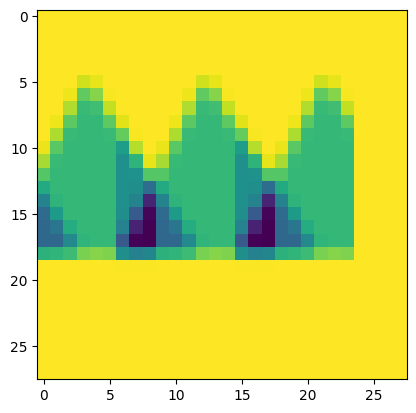

In [23]:
plt.imshow(generated_samples.detach().numpy())